In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np

train = np.load('/content/drive/Shared drives/Artists!/data_modified/train_log.npz')
print(train.files)
x_train = train['arr_0']
y_train = train['arr_1']
print(x_train.shape,y_train.shape)

['arr_0', 'arr_1']
(6527, 640, 128) (6527, 17)


In [0]:
val = np.load('/content/drive/Shared drives/Artists!/data_modified/val_log.npz')
x_val = val['arr_0']
y_val = val['arr_1']
print(x_val.shape,y_val.shape)

(814, 640, 128) (814, 17)


In [0]:
test = np.load('/content/drive/Shared drives/Artists!/data_modified/test_log.npz')
x_test = test['arr_0']
y_test = test['arr_1']
print(x_test.shape,y_test.shape)

(823, 640, 128) (823,)


In [0]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [0]:
import numpy as np
import os
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Bidirectional, LSTM, Dropout, Activation, GRU
from keras.layers import Conv2D, concatenate, MaxPooling2D, Flatten, Embedding, Lambda


from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop

from keras import regularizers


import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
BATCH_SIZE = 256
EPOCH_COUNT = 100
num_classes = 17
n_features = x_train.shape[2]
n_time = x_train.shape[1]

In [0]:
nb_filters1=32 
nb_filters2=32 
nb_filters3=64
nb_filters4=64
nb_filters5=64

ksize = (3,1)
pool_size_1= (2,2) 
pool_size_2= (2,2)
pool_size_3 = (4,2)

dropout_prob = 0.20
dense_size1 = 128
lstm_count = 64
num_units = 120

L2_regularization = 0.001

In [0]:
def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### Convolutional blocks
    conv_1 = Conv2D(filters = nb_filters1, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_1')(layer)
    pool_1 = MaxPooling2D(pool_size_1)(conv_1)

    conv_2 = Conv2D(filters = nb_filters2, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_2')(pool_1)
    pool_2 = MaxPooling2D(pool_size_1)(conv_2)

    conv_3 = Conv2D(filters = nb_filters3, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_3')(pool_2)
    pool_3 = MaxPooling2D(pool_size_1)(conv_3)
    
    
    conv_4 = Conv2D(filters = nb_filters4, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_4')(pool_3)
    pool_4 = MaxPooling2D(pool_size_2)(conv_4)
    
    
    conv_5 = Conv2D(filters = nb_filters5, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_5')(pool_4)
    pool_5 = MaxPooling2D(pool_size_2)(conv_5)

    flatten1 = Flatten()(pool_5)
    ### Recurrent Block
    
    # Pooling layer
    pool_lstm1 = MaxPooling2D(pool_size_3, name = 'pool_lstm')(layer)
    
    # Embedding layer

    squeezed = Lambda(lambda x: K.squeeze(x, axis= -1))(pool_lstm1)
#     flatten2 = K.squeeze(pool_lstm1, axis = -1)
#     dense1 = Dense(dense_size1)(flatten)
    
    # Bidirectional GRU
    lstm = Bidirectional(GRU(lstm_count))(squeezed)  #default merge mode is concat
    
    # Concat Output
    concat = concatenate([flatten1, lstm], axis=-1, name ='concat')
    
    ## Softmax Output
    output = Dense(num_classes, activation = 'softmax', name='preds')(concat)
    
    model_output = output
    model = Model(model_input, model_output)
    
    opt = Adam(lr=0.001)
    # opt = RMSprop(lr=0.0005)  # Optimizer
    model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )
    
    print(model.summary())
    return model

In [0]:
def train_model(x_train, y_train, x_val, y_val):
    
    n_frequency = 128
    n_frames = 640
    #reshape and expand dims for conv2d
#     x_train = x_train.reshape(-1, n_frequency, n_frames)
    x_train = np.expand_dims(x_train, axis = -1)
    
#     x_val = x_val.reshape(-1, n_frequency, n_frames)
    x_val = np.expand_dims(x_val, axis = -1)
    
    
    input_shape = (n_frames, n_frequency, 1)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
#     tb_callback = TensorBoard(log_dir='./logs/4', histogram_freq=1, batch_size=32, write_graph=True, write_grads=False,
#                               write_images=False, embeddings_freq=0, embeddings_layer_names=None,
#                               embeddings_metadata=None)
    checkpoint_callback = ModelCheckpoint('/content/drive/Shared drives/Artists!/model/weights.best_adam_n.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(
                monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
    callbacks_list = [checkpoint_callback, reducelr_callback]

    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
                        validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)

    return model, history

In [0]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [0]:
model, history  = train_model(x_train, y_train, x_val, y_val)


Building model...





Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 640, 128, 1)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 638, 128, 32) 128         input[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 319, 64, 32)  0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 317, 64, 32)  3104        max_pooling2d_1[0][0]            
____________________________________________________________________

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


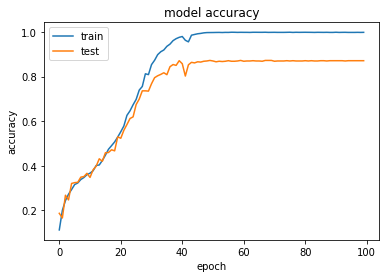

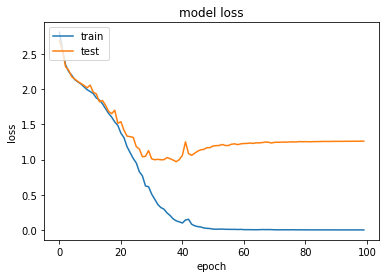

In [0]:
show_summary_stats(history)


In [0]:
from sklearn.metrics import classification_report
y_true = np.argmax(y_val, axis = 1)
x_valid = np.expand_dims(x_val, axis = -1)
y_pred = model.predict(x_valid)
y_pred = np.argmax(y_pred, axis=1)
# target_names = ['2', '4','5','10','12','15','17','18','21','25','26','38','181','182','297','468','1235']
target_names = ['International', 'Jazz','Classical','Pop','Rock','Electronic','Folk','Soundtrack','Hip-Hop','Punk','Post-Rock','Experimental','Techno','House','Chip Music','Dubstep','Instrumental']


print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))


(814,) (814,)
               precision    recall  f1-score   support

International       0.84      0.89      0.86        53
         Jazz       0.89      0.89      0.89        44
    Classical       0.84      0.93      0.88        45
          Pop       0.75      0.81      0.78        63
         Rock       0.87      0.76      0.81        51
   Electronic       0.83      0.83      0.83        53
         Folk       0.90      0.88      0.89        50
   Soundtrack       0.88      0.94      0.91        48
      Hip-Hop       0.88      0.84      0.86        44
         Punk       0.83      0.87      0.85        52
    Post-Rock       0.93      0.91      0.92        45
 Experimental       0.93      0.88      0.91        49
       Techno       0.90      0.87      0.89        54
        House       0.92      0.87      0.89        39
   Chip Music       0.96      0.88      0.92        50
      Dubstep       0.86      0.88      0.87        34
 Instrumental       0.88      0.93      0.90      

In [0]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

0.871007371007371


TEST

In [0]:
# test = np.load('/content/drive/Shared drives/Artists!/data_modified/test_log.npz')
# x_test = test['arr_0']
# y_test = test['arr_1']
# print(x_test.shape,y_test.shape)

In [0]:
from keras.models import load_model
weights_path = '/content/drive/Shared drives/Artists!/model/weights.best_adam_n.h5'
model_log = load_model(weights_path)

In [0]:
import pandas as pd
y_test_one = np.array(pd.get_dummies(y_test))

In [0]:
print(y_test_one.shape)

(823, 17)


In [0]:
from sklearn.metrics import classification_report

y_true = np.argmax(y_test_one, axis=1)
x_test = np.expand_dims(x_test, axis = -1)
y_pred = model_log.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
# target_names = ['2', '4','5','10','12','15','17','18','21','25','26','38','181','182','297','468','1235']
target_names = ['International', 'Jazz','Classical','Pop','Rock','Electronic','Folk','Soundtrack','Hip-Hop','Punk','Post-Rock','Experimental','Techno','House','Chip Music','Dubstep','Instrumental']


print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(823,) (823,)
               precision    recall  f1-score   support

International       0.96      0.96      0.96        56
         Jazz       0.77      0.79      0.78        29
    Classical       0.94      0.92      0.93        51
          Pop       0.85      0.84      0.85        49
         Rock       0.84      0.90      0.87        59
   Electronic       0.93      0.76      0.84        50
         Folk       0.86      0.82      0.84        51
   Soundtrack       0.85      0.85      0.85        54
      Hip-Hop       0.96      0.90      0.93        51
         Punk       0.86      0.96      0.91        53
    Post-Rock       0.91      0.84      0.88        38
 Experimental       0.82      0.82      0.82        50
       Techno       0.90      0.86      0.88        44
        House       0.82      0.90      0.86        40
   Chip Music       0.91      0.95      0.93        55
      Dubstep       0.78      0.84      0.81        51
 Instrumental       0.88      0.88      0.88      

In [0]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_true, y_pred))

0.8748481166464156


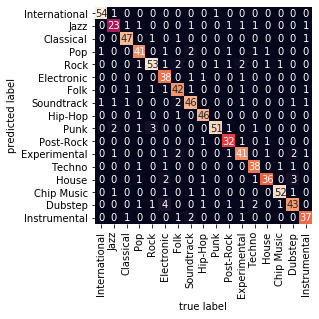

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');
